In [1]:
import requests
import lxml.html as lh
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
!pip install folium
import folium
import collections 
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

     |████████████████████████████████| 93 kB 4.0 MB/s  eta 0:00:01


In [3]:
URL = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai#Chembur'
mumbai_page = requests.get(URL)

doc = lh.fromstring(mumbai_page.content)

rows = doc.xpath('//tr')

In [4]:
cols = []

for column in rows[0]:
    cols.append(column.text_content()[:-1])
    
cols


['Area', 'Location', 'Latitude', 'Longitude']

In [5]:
data = []

for index, r in enumerate(rows):
    if index > 0:   
        row = []
        for value in r:
            row.append(value.text_content()[:-1])
        data.append(row)

In [6]:
mumbai_neighborhood = pd.DataFrame(data, columns=cols)

mumbai_neighborhood.head(10)

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.1293,72.8434
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.82721
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.82927
5,Marol,"Andheri,Western Suburbs",19.119219,72.882743
6,Sahar,"Andheri,Western Suburbs",19.098889,72.867222
7,Seven Bungalows,"Andheri,Western Suburbs",19.129052,72.817018
8,Versova,"Andheri,Western Suburbs",19.12,72.82
9,Mira Road,"Mira-Bhayandar,Western Suburbs",19.284167,72.871111


In [7]:
mumbai_neighborhood.shape

(93, 4)

Commercial Property Rate Data

In [8]:
url = 'https://drive.google.com/uc?export=download&id=1a2lBIVAgxwIPtavdJh7CLpObKaxXxuB9'
mumbai_property_rates = pd.read_csv(url)
mumbai_property_rates.head(10)

,Area,Location,Rate
0,Amboli,"Andheri,Western Suburbs",18000.0
1,"Chakala, Andheri",Western Suburbs,14750.0
2,D.N. Nagar,"Andheri,Western Suburbs",18000.0
3,Four Bungalows,"Andheri,Western Suburbs",18000.0
4,Lokhandwala,"Andheri,Western Suburbs",18000.0
5,Marol,"Andheri,Western Suburbs",14750.0
6,Sahar,"Andheri,Western Suburbs",14750.0
7,Seven Bungalows,"Andheri,Western Suburbs",18000.0
8,Versova,"Andheri,Western Suburbs",18000.0
9,Mira Road,"Mira-Bhayandar,Western Suburbs",8500.0


In [9]:
mumbai_data = pd.merge(mumbai_neighborhood, mumbai_property_rates, on=['Area', 'Location'])
mumbai_data.dropna(inplace=True)

new = mumbai_data["Location"].str.split(",", n = 1, expand = True) 
mumbai_data["Location"] = new[0] 
mumbai_data["Suburb"]= new[1] 

for i in range(mumbai_data.shape[0]):
    if mumbai_data.iloc[i, 5] is None:
        mumbai_data.iloc[i, 5] = mumbai_data.iloc[i, 1]

mumbai_data.reset_index(drop=True, inplace=True)

mumbai_data.head(10)

,Area,Location,Latitude,Longitude,Rate,Suburb
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs
5,Marol,Andheri,19.119219,72.882743,14750.0,Western Suburbs
6,Sahar,Andheri,19.098889,72.867222,14750.0,Western Suburbs
7,Seven Bungalows,Andheri,19.129052,72.817018,18000.0,Western Suburbs
8,Versova,Andheri,19.12,72.82,18000.0,Western Suburbs
9,Mira Road,Mira-Bhayandar,19.284167,72.871111,8500.0,Western Suburbs


In [10]:
mumbai_data.at[62, 'Longitude'] = 72.8478

mumbai_data.shape

(67, 6)

FourSquare API to find Restaurants near neighborhoods

In [11]:
CLIENT_ID = '3UEALH1TDZT45AQWNUWQOFZZPMXHLLQJRXNWXNRH1MPVHSQN'
CLIENT_SECRET = 'MF33UNOB5K2E4NXDVVQZVUFTNU3SJQAFNJMT3JMQ4LYXZWUK'
VERSION = '20180604'

In [12]:
LIMIT = 100
radius = 1000
venues = []

for latitude, longitude in zip(mumbai_data['Latitude'], mumbai_data['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    venues.append(requests.get(url).json())

In [13]:
food_joints = []
all_joints = []

for i in range(len(venues)):
    joints = []
    for j in range(len(venues[i]['response']['venues'])):
        try:
            if '/food/' in venues[i]['response']['venues'][j]['categories'][0]['icon']['prefix']:
                joints.append(str(venues[i]['response']['venues'][j]['categories'][0]['name']))
        except:
            pass
    food_joints.append(joints)
    
for i in range(len(venues)):
    joints = []
    for j in range(len(venues[i]['response']['venues'])):
        try:
            joints.append(str(venues[i]['response']['venues'][j]['categories'][0]['name']))
        except:
            pass
    all_joints.append(joints)

In [14]:
mumbai_data['Food Joints'] = food_joints
mumbai_data['All Joints'] = all_joints

mumbai_data.reset_index(drop=True, inplace = True)
mumbai_data.head(10)

,Area,Location,Latitude,Longitude,Rate,Suburb,Food Joints,All Joints
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Ice Cream Shop, Playground, Residential Build..."
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs,"[Asian Restaurant, Indian Restaurant, Asian Re...","[Asian Restaurant, Indian Restaurant, Asian Re..."
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs,"[Seafood Restaurant, Restaurant, Restaurant, I...","[Post Office, Seafood Restaurant, High School,..."
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs,"[Burger Joint, Snack Place, Cupcake Shop, Café...","[Residential Building (Apartment / Condo), Res..."
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Food Tr...","[Supermarket, Light Rail Station, Accessories ..."
5,Marol,Andheri,19.119219,72.882743,14750.0,Western Suburbs,"[Snack Place, Ice Cream Shop, Ice Cream Shop, ...","[Housing Development, Hostel, School, Professi..."
6,Sahar,Andheri,19.098889,72.867222,14750.0,Western Suburbs,"[Indian Restaurant, Pastry Shop, Breakfast Spo...","[Church, Indian Restaurant, Airport, Airport, ..."
7,Seven Bungalows,Andheri,19.129052,72.817018,18000.0,Western Suburbs,"[South Indian Restaurant, Seafood Restaurant, ...","[Pub, South Indian Restaurant, Seafood Restaur..."
8,Versova,Andheri,19.12,72.82,18000.0,Western Suburbs,"[Fast Food Restaurant, Café, French Restaurant...","[Beach, Beach, Spa, Bank, Bank, Fast Food Rest..."
9,Mira Road,Mira-Bhayandar,19.284167,72.871111,8500.0,Western Suburbs,"[Indian Restaurant, Chinese Restaurant, Americ...","[Residential Building (Apartment / Condo), Hou..."


Considering all venues near a Neighborhood for explotary data anaysis

In [15]:
latitude = []
longitude = []
suburbs = []
area = []
category = []

for i in range(len(venues)):
    count = 0
    for j in range(len(venues[i]['response']['venues'])):
        try:
            latitude.append(venues[i]['response']['venues'][j]['location']['lat'])
            longitude.append(venues[i]['response']['venues'][j]['location']['lng'])
            category.append(venues[i]['response']['venues'][j]['categories'][0]['name'])
        except:
            pass
    suburbs.extend([mumbai_data.iloc[i, 5]]*len(mumbai_data.iloc[i, 7]))
    area.extend([mumbai_data.iloc[i, 0]]*len(mumbai_data.iloc[i, 7]))

In [16]:
restaurants = []

for joints in mumbai_data['All Joints']:
    restaurants.extend(joints)

restaurants = pd.DataFrame({'Category':restaurants, 'Suburbs':suburbs, 'Area':area}, columns=['Category', 'Suburbs', 'Area'])
restaurants = restaurants.merge(mumbai_data.set_index('Area'), on='Area')
restaurants.drop(['Food Joints'], axis = 1, inplace = True)

In [17]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Suburb'] = restaurants['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Suburb').mean().reset_index()

num_top_venues = 5

for hood in restaurant_grouped['Suburb']:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Eastern Suburbs----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                         Indian Restaurant  0.05
2                                    Office  0.04
3                        Salon / Barbershop  0.03
4                       Housing Development  0.02


----Harbour Suburbs----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.11
1                                      Bank  0.07
2                         Indian Restaurant  0.04
3                       Housing Development  0.03
4                                       Gym  0.02


----South Mumbai----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.09
1                                    Office  0.07
2                         Indian Restaurant  0.04
3                                      Bank  0.03
4                                  Building  0.03


----Western Suburbs----
 

Considering only Food Venues near a Neighborhood

In [21]:
latitude = []
longitude = []
suburbs = []
area = []
category = []

for i in range(len(venues)):
    count = 0
    for j in range(len(venues[i]['response']['venues'])):
        try:
            if '/food/' in venues[i]['response']['venues'][j]['categories'][0]['icon']['prefix']:
                latitude.append(venues[i]['response']['venues'][j]['location']['lat'])
                longitude.append(venues[i]['response']['venues'][j]['location']['lng'])
                category.append(venues[i]['response']['venues'][j]['categories'][0]['name'])
        except:
            pass
    suburbs.extend([mumbai_data.iloc[i, 5]]*len(mumbai_data.iloc[i, 6]))
    area.extend([mumbai_data.iloc[i, 0]]*len(mumbai_data.iloc[i, 6]))

In [19]:
mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

suburb_names = ['Western Suburbs', 'Eastern Suburbs', 'Harbour Suburbs', 'South Mumbai']
colors = ['red', 'blue', 'green', 'yellow']

for lat, long, name, suburb in zip(latitude, longitude, category, suburbs):
    label = folium.Popup(str(name))
    folium.CircleMarker(
        [lat, long], 
        radius=5,
        popup=label,
        color=colors[suburb_names.index(suburb)],
        fill=True, 
        fill_opacity=0.7
    ).add_to(mumbai_map)
    
display(mumbai_map)

In [22]:
restaurants = []

for joints in mumbai_data['Food Joints']:
    restaurants.extend(joints)

restaurants = pd.DataFrame({'Category':restaurants, 'Suburbs':suburbs, 'Area':area}, columns=['Category', 'Suburbs', 'Area'])
restaurants = restaurants.merge(mumbai_data.set_index('Area'), on='Area')
restaurants.drop(['Food Joints'], axis = 1, inplace = True)

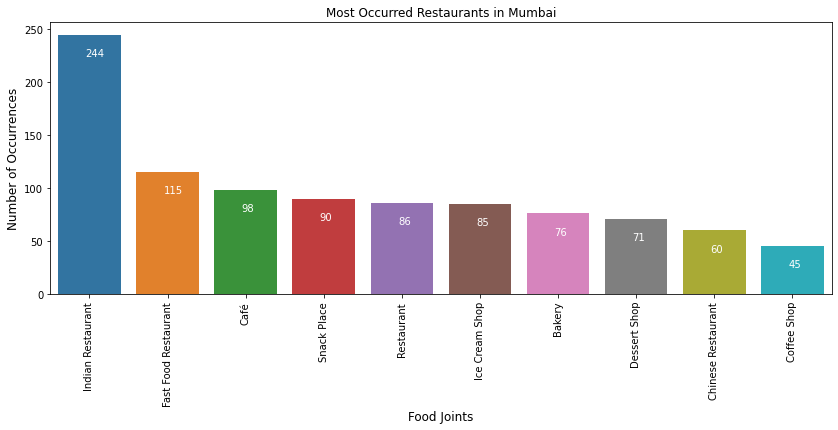

In [23]:
x = restaurants['Category'].value_counts()[:10].index
y = restaurants['Category'].value_counts()[:10].values

plt.figure(figsize=(14,5))
sns.barplot(x, y)
plt.xticks(rotation=90)
plt.title('Most Occurred Restaurants in Mumbai')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Food Joints', fontsize=12)

for index, value in enumerate(y):
    plt.annotate(value, xy=(index - 0.05, value - 20), color='white')

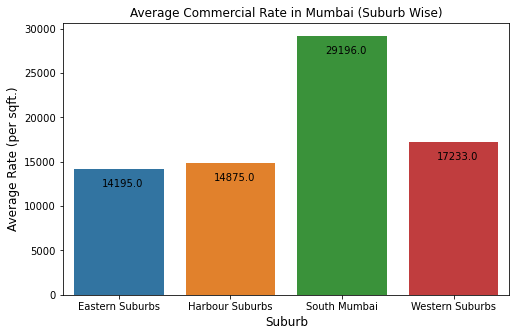

In [24]:
x = mumbai_data.groupby('Suburb')['Rate'].mean().index
y = np.round_(mumbai_data.groupby('Suburb')['Rate'].mean().values)

plt.figure(figsize=(8,5))
sns.barplot(x, y)
plt.title('Average Commercial Rate in Mumbai (Suburb Wise)')
plt.ylabel('Average Rate (per sqft.)', fontsize=12)
plt.xlabel('Suburb', fontsize=12)

for index, value in enumerate(y):
    plt.annotate(value, xy=(index - 0.15, value - 2000), color='black')

In [25]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Suburb'] = restaurants['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Suburb').mean().reset_index()

restaurant_grouped.head()

,Suburb,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,...,Street Food Gathering,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery
0,Eastern Suburbs,0.004202,0.004202,0.000000,0.000000,0.000000,0.046218,0.004202,0.004202,0.004202,...,0.000000,0.012605,0.004202,0.000000,0.000000,0.000000,0.004202,0.000000,0.000000,0.000000
1,Harbour Suburbs,0.000000,0.031250,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
2,South Mumbai,0.002151,0.012903,0.000000,0.000000,0.000000,0.023656,0.000000,0.000000,0.008602,...,0.000000,0.010753,0.002151,0.002151,0.000000,0.004301,0.012903,0.000000,0.006452,0.002151
3,Western Suburbs,0.001267,0.006337,0.002535,0.001267,0.001267,0.019011,0.001267,0.000000,0.007605,...,0.001267,0.013942,0.001267,0.000000,0.003802,0.001267,0.012674,0.001267,0.002535,0.002535


In [26]:
num_top_venues = 10

for hood in restaurant_grouped['Suburb']:
    print("----"+hood+"----")
    temp = restaurant_grouped[restaurant_grouped['Suburb'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Eastern Suburbs----
                  venue  freq
0     Indian Restaurant  0.19
1  Fast Food Restaurant  0.08
2            Restaurant  0.07
3        Ice Cream Shop  0.06
4                Bakery  0.06
5           Snack Place  0.05
6      Asian Restaurant  0.05
7          Dessert Shop  0.04
8                  Café  0.04
9    Chinese Restaurant  0.03


----Harbour Suburbs----
                     venue  freq
0        Indian Restaurant  0.25
1     Fast Food Restaurant  0.12
2              Coffee Shop  0.06
3                   Bakery  0.06
4              Snack Place  0.06
5         Asian Restaurant  0.06
6  Comfort Food Restaurant  0.03
7                    Diner  0.03
8      Dumpling Restaurant  0.03
9               Food Truck  0.03


----South Mumbai----
                  venue  freq
0     Indian Restaurant  0.17
1  Fast Food Restaurant  0.08
2                  Café  0.07
3        Ice Cream Shop  0.05
4           Snack Place  0.05
5          Dessert Shop  0.05
6            Restaurant 

Clustering Neighborhoods

In [27]:
restaurant_onehot = pd.get_dummies(restaurants['Category'])

# add neighborhood column back to dataframe
restaurant_onehot['Area'] = restaurants['Area'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_grouped = restaurant_onehot.groupby('Area').mean().reset_index()

restaurant_grouped.head()

,Area,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,...,Street Food Gathering,Tea Room,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery
0,Aarey Milk Colony,0.0,0.031250,0.03125,0.0,0.0,0.000000,0.031250,0.0,0.000000,...,0.0,0.062500,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Altamount Road,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Amboli,0.0,0.000000,0.00000,0.0,0.0,0.043478,0.000000,0.0,0.000000,...,0.0,0.043478,0.000000,0.0,0.0,0.0,0.043478,0.0,0.0,0.0
3,Amrut Nagar,0.0,0.035714,0.00000,0.0,0.0,0.071429,0.035714,0.0,0.035714,...,0.0,0.035714,0.035714,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Asalfa,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=columns)
restaurant_sorted['Area'] = restaurant_grouped['Area']

for ind in np.arange(restaurant_grouped.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_grouped.iloc[ind, :], num_top_venues)

restaurant_sorted = restaurant_sorted.merge(mumbai_data[['Area', 'Rate']].set_index('Area'), on='Area')   

restaurant_sorted.head(10)

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate
0,Aarey Milk Colony,Indian Restaurant,Snack Place,Café,Restaurant,Tea Room,Chinese Restaurant,American Restaurant,Chaat Place,Pizza Place,Fast Food Restaurant,12950.0
1,Altamount Road,Ice Cream Shop,Café,Food Truck,Restaurant,Cupcake Shop,Dessert Shop,Bakery,Fast Food Restaurant,Indian Restaurant,Food,45000.0
2,Amboli,Chinese Restaurant,Snack Place,Fast Food Restaurant,Indian Restaurant,Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Sandwich Place,Coffee Shop,Tea Room,18000.0
3,Amrut Nagar,Indian Restaurant,Fast Food Restaurant,Brewery,Ice Cream Shop,Asian Restaurant,Restaurant,Bagel Shop,Frozen Yogurt Shop,Dumpling Restaurant,Burger Joint,16150.0
4,Asalfa,Indian Restaurant,Bakery,Café,Food Truck,Dessert Shop,Donut Shop,Winery,Falafel Restaurant,Creperie,Cuban Restaurant,16150.0
5,Ballard Estate,Indian Restaurant,Breakfast Spot,Dessert Shop,Snack Place,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food Truck,Restaurant,Seafood Restaurant,BBQ Joint,29000.0
6,Bandstand Promenade,Coffee Shop,Café,Fast Food Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Food Truck,Breakfast Spot,Bakery,Ice Cream Shop,30000.0
7,Bangur Nagar,Indian Restaurant,Food Truck,BBQ Joint,Bakery,Coffee Shop,Pizza Place,Juice Bar,Restaurant,Café,Mexican Restaurant,13500.0
8,Bhandup,Indian Restaurant,Café,Restaurant,Chinese Restaurant,Fast Food Restaurant,Diner,Afghan Restaurant,South Indian Restaurant,Fried Chicken Joint,Pizza Place,15000.0
9,Bhayandar,Fast Food Restaurant,Indian Restaurant,Ice Cream Shop,Bakery,Dessert Shop,Vegetarian / Vegan Restaurant,Pizza Place,Food Truck,Restaurant,Burger Joint,8000.0


In [30]:
model = KMeans(init='k-means++', n_clusters=4, random_state=0).fit(restaurant_grouped.iloc[:, 1:])

restaurant_sorted.insert(1, 'Cluster Label', model.labels_)

restaurant_final = mumbai_data.copy()
restaurant_final = restaurant_final.merge(restaurant_sorted.set_index('Area'), on='Area')
restaurant_final.dropna(axis=0, inplace=True)

restaurant_final.head()

,Area,Location,Latitude,Longitude,Rate_x,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
0,Amboli,Andheri,19.1293,72.8434,18000.0,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Ice Cream Shop, Playground, Residential Build...",3,Chinese Restaurant,Snack Place,Fast Food Restaurant,Indian Restaurant,Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Sandwich Place,Coffee Shop,Tea Room,18000.0
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,14750.0,Western Suburbs,"[Asian Restaurant, Indian Restaurant, Asian Re...","[Asian Restaurant, Indian Restaurant, Asian Re...",1,Indian Restaurant,Fast Food Restaurant,Pizza Place,Café,Restaurant,Coffee Shop,Asian Restaurant,Bakery,Snack Place,Korean Restaurant,14750.0
2,D.N. Nagar,Andheri,19.124085,72.831373,18000.0,Western Suburbs,"[Seafood Restaurant, Restaurant, Restaurant, I...","[Post Office, Seafood Restaurant, High School,...",2,Restaurant,Ice Cream Shop,Indian Restaurant,Café,Pizza Place,Dessert Shop,Breakfast Spot,Seafood Restaurant,Snack Place,Chinese Restaurant,18000.0
3,Four Bungalows,Andheri,19.124714,72.82721,18000.0,Western Suburbs,"[Burger Joint, Snack Place, Cupcake Shop, Café...","[Residential Building (Apartment / Condo), Res...",0,Fast Food Restaurant,Cupcake Shop,Café,Burger Joint,BBQ Joint,Snack Place,Bakery,Falafel Restaurant,Cuban Restaurant,Deli / Bodega,18000.0
4,Lokhandwala,Andheri,19.130815,72.82927,18000.0,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Food Tr...","[Supermarket, Light Rail Station, Accessories ...",1,Indian Restaurant,Café,Juice Bar,Food Truck,Coffee Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,18000.0


In [31]:
mumbai_map = folium.Map(location=[19.0760, 72.8777], zoom_start=11)

colors = ['red', 'blue', 'green', 'yellow']

for lat, lon, neighborhood, cluster in zip(restaurant_final['Latitude'], restaurant_final['Longitude'], restaurant_final['Area'], restaurant_final['Cluster Label']):
    label = folium.Popup(str(neighborhood))
    folium.CircleMarker(
        [lat, lon], 
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True, 
        fill_opacity=0.7
    ).add_to(mumbai_map)
    
display(mumbai_map)

In [32]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 1, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
1,Western Suburbs,Western Suburbs,"[Asian Restaurant, Indian Restaurant, Asian Re...","[Asian Restaurant, Indian Restaurant, Asian Re...",1,Indian Restaurant,Fast Food Restaurant,Pizza Place,Café,Restaurant,Coffee Shop,Asian Restaurant,Bakery,Snack Place,Korean Restaurant,14750.0
4,Andheri,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Food Tr...","[Supermarket, Light Rail Station, Accessories ...",1,Indian Restaurant,Café,Juice Bar,Food Truck,Coffee Shop,Winery,Dumpling Restaurant,Creperie,Cuban Restaurant,Cupcake Shop,18000.0
15,Borivali (West),Western Suburbs,"[Indian Restaurant, Seafood Restaurant, Pizza ...","[Beach, Resort, Whisky Bar, Indian Restaurant,...",1,Indian Restaurant,Café,Restaurant,Dessert Shop,Breakfast Spot,Coffee Shop,Fast Food Restaurant,Juice Bar,Chinese Restaurant,Food,10550.0
16,Western Suburbs,Western Suburbs,"[Sandwich Place, Pizza Place, Fast Food Restau...","[Train Station, Bank, Dog Run, Bank, Spa, Sand...",1,Indian Restaurant,Snack Place,Dessert Shop,Restaurant,Sandwich Place,Chinese Restaurant,Bakery,Fast Food Restaurant,Café,Tea Room,9500.0
17,Goregaon,Western Suburbs,"[Snack Place, Snack Place, Snack Place, Café, ...","[Farm, Residential Building (Apartment / Condo...",1,Indian Restaurant,Snack Place,Café,Restaurant,Tea Room,Chinese Restaurant,American Restaurant,Chaat Place,Pizza Place,Fast Food Restaurant,12950.0
18,Goregaon,Western Suburbs,"[Coffee Shop, Food Truck, Food Truck, Bakery, ...","[Temple, Coffee Shop, General Entertainment, R...",1,Indian Restaurant,Food Truck,BBQ Joint,Bakery,Coffee Shop,Pizza Place,Juice Bar,Restaurant,Café,Mexican Restaurant,13500.0
26,Khar,Western Suburbs,"[Indian Restaurant, Bakery, Seafood Restaurant...","[Indian Restaurant, Pub, Platform, Bakery, Sea...",1,Indian Restaurant,Café,Restaurant,Pizza Place,Bakery,Food Truck,Indian Sweet Shop,Juice Bar,Dessert Shop,Cupcake Shop,21500.0
30,Vile Parle,Western Suburbs,"[Indian Restaurant, Indian Restaurant, Indian ...","[Indian Restaurant, Market, Bar, Indian Restau...",1,Indian Restaurant,Food Truck,Juice Bar,Coffee Shop,Winery,Cuban Restaurant,Café,Burger Joint,Restaurant,Fast Food Restaurant,20750.0
32,Eastern Suburbs,Eastern Suburbs,"[Indian Restaurant, Fried Chicken Joint, Café,...","[Indian Restaurant, Gas Station, Multiplex, Sh...",1,Indian Restaurant,Café,Restaurant,Chinese Restaurant,Fast Food Restaurant,Diner,Afghan Restaurant,South Indian Restaurant,Fried Chicken Joint,Pizza Place,15000.0
34,Ghatkopar,Eastern Suburbs,"[Bakery, Indian Restaurant, Donut Shop, Café, ...","[Light Rail Station, Assisted Living, Bus Stat...",1,Indian Restaurant,Bakery,Café,Food Truck,Dessert Shop,Donut Shop,Winery,Falafel Restaurant,Creperie,Cuban Restaurant,16150.0


In [33]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 2, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
2,Andheri,Western Suburbs,"[Seafood Restaurant, Restaurant, Restaurant, I...","[Post Office, Seafood Restaurant, High School,...",2,Restaurant,Ice Cream Shop,Indian Restaurant,Café,Pizza Place,Dessert Shop,Breakfast Spot,Seafood Restaurant,Snack Place,Chinese Restaurant,18000.0
6,Andheri,Western Suburbs,"[Indian Restaurant, Pastry Shop, Breakfast Spo...","[Church, Indian Restaurant, Airport, Airport, ...",2,Restaurant,Café,Indian Restaurant,Breakfast Spot,Coffee Shop,Ice Cream Shop,Fast Food Restaurant,Cupcake Shop,Deli / Bodega,South Indian Restaurant,14750.0
7,Andheri,Western Suburbs,"[South Indian Restaurant, Seafood Restaurant, ...","[Pub, South Indian Restaurant, Seafood Restaur...",2,Ice Cream Shop,Indian Restaurant,Café,Chinese Restaurant,Pizza Place,Dessert Shop,Seafood Restaurant,Bistro,Coffee Shop,Mexican Restaurant,18000.0
8,Andheri,Western Suburbs,"[Fast Food Restaurant, Café, French Restaurant...","[Beach, Beach, Spa, Bank, Bank, Fast Food Rest...",2,Greek Restaurant,Indian Restaurant,Café,French Restaurant,Snack Place,Fast Food Restaurant,Donut Shop,Comfort Food Restaurant,Creperie,Cuban Restaurant,18000.0
12,Bandra,Western Suburbs,"[Snack Place, Restaurant, Chinese Restaurant, ...","[Snack Place, Gourmet Shop, Pharmacy, Market, ...",2,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Dessert Shop,Café,Restaurant,Chinese Restaurant,Gastropub,Burger Joint,Bubble Tea Shop,27500.0
13,Bandra,Western Suburbs,"[Indian Restaurant, Bakery, Food Truck, Fast F...","[Indian Restaurant, Laundry Service, Bakery, C...",2,Indian Restaurant,Bakery,Restaurant,Breakfast Spot,Fast Food Restaurant,Ice Cream Shop,Chinese Restaurant,Cupcake Shop,Pizza Place,Café,30000.0
19,Western Suburbs,Western Suburbs,"[Asian Restaurant, Juice Bar, Sandwich Place, ...","[Light Rail Station, Courthouse, Asian Restaur...",2,Indian Restaurant,Restaurant,Bakery,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Sandwich Place,Ice Cream Shop,Food Truck,Juice Bar,Pizza Place,17000.0
24,Kandivali East,Western Suburbs,"[Belgian Restaurant, Café, Dessert Shop, Soup ...","[Belgian Restaurant, Café, Park, Indie Theater...",2,Ice Cream Shop,Café,Food Truck,Snack Place,Indian Restaurant,Cupcake Shop,Juice Bar,Sandwich Place,Soup Place,Vietnamese Restaurant,11500.0
25,Khar,Western Suburbs,"[Indian Restaurant, Seafood Restaurant, Seafoo...","[Indian Restaurant, Bar, Seafood Restaurant, P...",2,Indian Restaurant,Seafood Restaurant,Snack Place,Fast Food Restaurant,Chinese Restaurant,Café,Burger Joint,South American Restaurant,French Restaurant,Food Truck,21500.0
28,Malad,Western Suburbs,"[Café, Coffee Shop, Bubble Tea Shop, Chinese R...","[Garden, Bank, School, College Communications ...",2,Indian Restaurant,Café,Ice Cream Shop,Snack Place,Italian Restaurant,Fast Food Restaurant,Diner,Coffee Shop,Chinese Restaurant,Restaurant,13600.0


In [34]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 3, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
0,Andheri,Western Suburbs,"[Ice Cream Shop, Vegetarian / Vegan Restaurant...","[Ice Cream Shop, Playground, Residential Build...",3,Chinese Restaurant,Snack Place,Fast Food Restaurant,Indian Restaurant,Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Sandwich Place,Coffee Shop,Tea Room,18000.0
9,Mira-Bhayandar,Western Suburbs,"[Indian Restaurant, Chinese Restaurant, Americ...","[Residential Building (Apartment / Condo), Hou...",3,Chinese Restaurant,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Winery,Pizza Place,American Restaurant,Breakfast Spot,Coffee Shop,Cupcake Shop,8500.0
11,Bandra,Western Suburbs,"[Café, Italian Restaurant, Indian Restaurant, ...","[Hotel, Performing Arts Venue, Scenic Lookout,...",3,Coffee Shop,Café,Fast Food Restaurant,Chinese Restaurant,Restaurant,Indian Restaurant,Food Truck,Breakfast Spot,Bakery,Ice Cream Shop,30000.0
21,Kandivali West,Western Suburbs,"[Ice Cream Shop, Fish & Chips Shop, Food, Indi...","[Miscellaneous Shop, Government Building, Ice ...",3,Chinese Restaurant,Indian Restaurant,Pizza Place,Ice Cream Shop,Cupcake Shop,Italian Restaurant,Bakery,Multicuisine Indian Restaurant,Restaurant,Seafood Restaurant,15500.0
22,Kandivali West,Western Suburbs,"[Pizza Place, BBQ Joint, Ice Cream Shop, Fast ...","[Temple, College Academic Building, General Tr...",3,Fast Food Restaurant,Ice Cream Shop,Indian Restaurant,Coffee Shop,Chinese Restaurant,BBQ Joint,Snack Place,Food Truck,Juice Bar,Café,15500.0
36,Eastern Suburbs,Eastern Suburbs,"[Indian Restaurant, Bakery, Ice Cream Shop, It...","[Multiplex, Indian Restaurant, Bridge, Bakery,...",3,Ice Cream Shop,Indian Restaurant,Chinese Restaurant,Bakery,Fast Food Restaurant,Asian Restaurant,Italian Restaurant,French Restaurant,Cupcake Shop,Restaurant,10550.0
52,South Mumbai,South Mumbai,"[Vegetarian / Vegan Restaurant, Italian Restau...","[Scenic Lookout, General Entertainment, Doctor...",3,Chinese Restaurant,Food Truck,Café,Cupcake Shop,Snack Place,Bistro,Italian Restaurant,South Indian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,40000.0
53,South Mumbai,South Mumbai,"[Ice Cream Shop, South Indian Restaurant, Bake...","[Train Station, Capitol Building, General Ente...",3,Chinese Restaurant,Ice Cream Shop,Café,Seafood Restaurant,Snack Place,Bistro,South Indian Restaurant,Juice Bar,Bakery,Italian Restaurant,29000.0
58,South Mumbai,South Mumbai,"[Ice Cream Shop, Coffee Shop, Maharashtrian Re...","[Ice Cream Shop, Coffee Shop, Salon / Barbersh...",3,Fast Food Restaurant,Coffee Shop,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Maharashtrian Restaurant,Dessert Shop,Chinese Restaurant,Awadhi Restaurant,Cupcake Shop,43000.0


In [37]:
restaurant_final.loc[restaurant_final['Cluster Label'] == 4, restaurant_final.columns[[1] + list(range(5, restaurant_final.shape[1]))]]

,Location,Suburb,Food Joints,All Joints,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Rate_y
